In [26]:
%matplotlib inline
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from random import shuffle
import sys
import random
from collections import deque
from math import ceil
import copy
import itertools

plt.rcParams["figure.figsize"] = (30,20)

%load_ext autoreload
%autoreload 2

from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

sys.path.append(f"{paths.inhouse}/dif/python")
import oce_waveform_utils as oce_wf_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Waveform Variable Range Table

|Var  |BI |AA |AB  |AC  |AD   |AE  |AF  |WT   |CA  |HT  |CB  |PA  |CC   |PB   |CD  |PC   |CE   |PD   |CF  |
|-----|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|Val 1| 20|10 | -25| 15 | -6  |3.6 |2.4 |1    |0.4 |0.6 |1   |0.1 |0.5  |0.2  |0.5 |0.3  |1    |1    | 0.5|
|Val 2|30 |5  |-10 |10  |-3.6 |-5  |3.6 |0.1  |1   |1.5 |1.5 |0.3 |0.8  |0.7  |1   |1.2  |1.5  |1.5  | 1.2|
|Fxn  |-|-|- |- |-  |- |- |CBxAF|- |- |- |- |HTxAE|CAxPD|- |-  |BIxCD|AAxPC|- |



In [2]:
WF_var_ranges = {
    "WF_parms": {
        "BI": [20  , 30  , []],
        "AA": [10  , 5   , []],
        "AB": [-25 , -10 , []],
        "AC": [15  , 10  , []],
        "AD": [-6  , -3.6, []],
        "AE": [3.6 , -5  , []],
        "AF": [2.4 , 3.6 , []],
        "WT": [1   , 0.1 , ["CB","AF"]],
        "CA": [0.4 , 1   , []],
        "HT": [0.6 , 1.5 , []],
        "CB": [1   , 1.5 , []],
        "PA": [0.3 , 0.3 , []],
        "CC": [0.5 , 0.8 , ["HT","AE"]],
        "PB": [0.2 , 0.7 , ["CA","CF"]],
        "CD": [0.5 , 0.5 , []],
        "PC": [0.3 , 1.2 , []],
        "CE": [1   , 1.5 , ["BI","CD"]],
        "PD": [1   , 1.5 , ["AA","PC"]],
        "CF": [0.5 , 1.2 , []]
    }
}

WF_var_ranges_orig = {
    "WF_parms": {
        "BI": [20  , 30  , []],
        "AA": [10  , 5   , []],
        "AB": [-25 , -10 , []],
        "AC": [15  , 10  , []],
        "AD": [-6  , -3.6, []],
        "AE": [3.6 , -5  , []],
        "AF": [2.4 , 3.6 , []],
        "WT": [1   , 0.1 , ["CB","AF"]],
        "CA": [0.4 , 1   , []],
        "HT": [0.6 , 1.5 , []],
        "CB": [1   , 1.5 , []],
        "PA": [0.1 , 0.3 , []],
        "CC": [0.5 , 0.8 , ["HT","AE"]],
        "PB": [0.2 , 0.7 , ["CA","CF"]],
        "CD": [0.5 , 1   , []],
        "PC": [0.3 , 1.2 , []],
        "CE": [1   , 1.5 , ["BI","CD"]],
        "PD": [1   , 1.5 , ["AA","PC"]],
        "CF": [0.5 , 1.2 , []]
    }
}

#     "bias_ramp_vals": {
#         "lib1":  [[0,20,0,0,0,0,0,0,300,0,0,0,0,0,0,0,0,0,0],
#                   [0,20,0,0,0,0,0,0,300,0,0,0,0,0,0,0,0,0,0]],
#         "lib3":  [[20,-15,0,0,0,0,0,0,300,0,0,0,0,0,0,0,0,0,0],
#                   [20,-15,0,0,0,0,0,0,300,0,0,0,0,0,0,0,0,0,0]]
#     }


In [3]:
import json
with open(f'{paths.inhouse}/dif/python/WF_var_ranges.json', 'w') as fp:
    json.dump(WF_var_ranges, fp)

In [4]:
WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants  = oce_wf_utils.initialize_WF_vars(WF_var_ranges["WF_parms"])
num_fields = len(WF_var_header_fields)

print(f"Dependent vars   ({len(WF_var_dependents)}):", WF_var_dependents)
print(f"Independent vars ({len(WF_var_independents)}): {WF_var_independents}")
print(f"Constant vars ({len(WF_var_constants)}): {WF_var_constants}")
print(f"Headers ({len(WF_var_header_fields)}): {WF_var_header_fields}")

Dependent vars   (5): {'WT': [1, 0.1, ['CB', 'AF']], 'CC': [0.5, 0.8, ['HT', 'AE']], 'PB': [0.2, 0.7, ['CA', 'CF']], 'CE': [1, 1.5, ['BI', 'CD']], 'PD': [1, 1.5, ['AA', 'PC']]}
Independent vars (12): {'BI': [20, 30, []], 'AA': [10, 5, []], 'AB': [-25, -10, []], 'AC': [15, 10, []], 'AD': [-6, -3.6, []], 'AE': [3.6, -5, []], 'AF': [2.4, 3.6, []], 'CA': [0.4, 1, []], 'HT': [0.6, 1.5, []], 'CB': [1, 1.5, []], 'PC': [0.3, 1.2, []], 'CF': [0.5, 1.2, []]}
Constant vars (2): {'PA': [0.3, 0.3, []], 'CD': [0.5, 0.5, []]}
Headers (19): ['BI', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'WT', 'CA', 'HT', 'CB', 'PA', 'CC', 'PB', 'CD', 'PC', 'CE', 'PD', 'CF']


In [5]:
# '{0:b}'.format(42)
state = oce_wf_utils.toBinaryStr(19, 20)
print(state)

00000000000000010011


In [6]:
list(WF_var_independents.items())+list(WF_var_dependents.items())+list(WF_var_constants.items())

[('BI', [20, 30, []]),
 ('AA', [10, 5, []]),
 ('AB', [-25, -10, []]),
 ('AC', [15, 10, []]),
 ('AD', [-6, -3.6, []]),
 ('AE', [3.6, -5, []]),
 ('AF', [2.4, 3.6, []]),
 ('CA', [0.4, 1, []]),
 ('HT', [0.6, 1.5, []]),
 ('CB', [1, 1.5, []]),
 ('PC', [0.3, 1.2, []]),
 ('CF', [0.5, 1.2, []]),
 ('WT', [1, 0.1, ['CB', 'AF']]),
 ('CC', [0.5, 0.8, ['HT', 'AE']]),
 ('PB', [0.2, 0.7, ['CA', 'CF']]),
 ('CE', [1, 1.5, ['BI', 'CD']]),
 ('PD', [1, 1.5, ['AA', 'PC']]),
 ('PA', [0.3, 0.3, []]),
 ('CD', [0.5, 0.5, []])]

In [7]:
debug = True
iter = pow(2, (len(WF_var_independents))) - 1
iter = random.randint(1,pow(2, (len(WF_var_independents))) - 1)
print(f"Iter = {iter} ({oce_wf_utils.toBinaryStr(iter, len(WF_var_independents))})")

if debug:
    print("States Before...")
    try:
        for idx,(k,v) in enumerate(WF_var_states.items()):
            var_type = "d" if k in WF_var_dependents else "i" if k in WF_var_independents else "c"
            print(f"[{idx:02}] ({var_type}) {k}: {v}")
    except NameError:
        print("--> WF_var_states not yet defined...")

try:
    print("State before: " + oce_wf_utils.make_state_str(WF_var_states, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants ))
except NameError:
    print("--> WF_var_states not yet defined...")

WF_var_states, WF_var_values = oce_wf_utils.calc_state_and_vals(iter, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants, keep_orig_order=True, debug=True)

print("State after : " + oce_wf_utils.make_state_str(WF_var_states, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants ))
print(f"Independent States After: {oce_wf_utils.toBinaryStr(iter, len(WF_var_independents))}")

if debug: 
    print("States After...")
    for idx,(k,v) in enumerate(WF_var_states.items()):
        var_type = "d" if k in WF_var_dependents else "i" if k in WF_var_independents else "c"
        print(f"[{idx:02}] ({var_type}) {k}: {v}")
    print("Values After...")
    #for idx,(k,v) in enumerate(list(WF_var_independents.items())+list(WF_var_dependents.items())):
    for idx,(k,v) in enumerate(WF_var_states.items()):
        if k in WF_var_dependents:
            var_type = "d"
            vals = WF_var_dependents[k][:2]
            ansi_code = '\033[31m'
        elif k in WF_var_independents:
            var_type = "i"
            vals = WF_var_independents[k][:2]
            ansi_code = '\033[34m'
        else:
            var_type = "c"
            vals = WF_var_constants[k][:2]
            ansi_code = '\033[32m'
        print(ansi_code+f"[{idx:02}] ({var_type}) {k}: {WF_var_values[k]} (state: {WF_var_states[k]}, vals{vals})"+'\033[0m')

Iter = 2679 (101001110111)
States Before...
--> WF_var_states not yet defined...
--> WF_var_states not yet defined...
dependent var WT: CB xor AF -> 1 xor 1 = 0
dependent var CC: HT xor AE -> 0 xor 1 = 1
dependent var PB: CA xor CF -> 1 xor 1 = 0
dependent var CE: BI xor CD -> 1 xor 0 = 1
dependent var PD: AA xor PC -> 0 xor 1 = 1
State after : 1010011010101001111
Independent States After: 101001110111
States After...
[00] (i) BI: 1
[01] (i) AA: 0
[02] (i) AB: 1
[03] (i) AC: 0
[04] (i) AD: 0
[05] (i) AE: 1
[06] (i) AF: 1
[07] (d) WT: 0
[08] (i) CA: 1
[09] (i) HT: 0
[10] (i) CB: 1
[11] (c) PA: 0
[12] (d) CC: 1
[13] (d) PB: 0
[14] (c) CD: 0
[15] (i) PC: 1
[16] (d) CE: 1
[17] (d) PD: 1
[18] (i) CF: 1
Values After...
[00] (i) BI: 30 (state: 1, vals[20, 30])
[01] (i) AA: 10 (state: 0, vals[10, 5])
[02] (i) AB: -10 (state: 1, vals[-25, -10])
[03] (i) AC: 15 (state: 0, vals[15, 10])
[04] (i) AD: -6 (state: 0, vals[-6, -3.6])
[05] (i) AE: -5 (state: 1, vals[3.6, -5])
[06] (i) AF: 3.6 (state: 1

In [8]:
print([WF_var_values[k] for k in WF_var_header_fields])
print(WF_var_values.items())

[30, 10, -10, 15, -6, -5, 3.6, 1, 1, 0.6, 1.5, 0.3, 0.8, 0.2, 0.5, 1.2, 1.5, 1.5, 1.2]
dict_items([('BI', 30), ('AA', 10), ('AB', -10), ('AC', 15), ('AD', -6), ('AE', -5), ('AF', 3.6), ('WT', 1), ('CA', 1), ('HT', 0.6), ('CB', 1.5), ('PA', 0.3), ('CC', 0.8), ('PB', 0.2), ('CD', 0.5), ('PC', 1.2), ('CE', 1.5), ('PD', 1.5), ('CF', 1.2)])


In [9]:
'''
    Test number 1: Call calc_state_and_vals for all values between 0 and 2^14 (14 == num independent vars), put state_str into set. 
    Resulting set size should equal 2^14...
'''
cnt = pow(2,(len(WF_var_independents)))

s = set()
for iter in range(cnt):
    states, values = oce_wf_utils.calc_state_and_vals(iter, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants, keep_orig_order=True, debug=False)
    state_str = oce_wf_utils.make_state_str(states, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants, False )
    #print(state_str+util.RESET)
    s.add(state_str)

assert cnt == len(s), f"iter cnt != set len: ({cnt}) != ({len(s)})"

print(f"Test okay: cnt: {cnt} == set len: {len(s)}")

Test okay: cnt: 4096 == set len: 4096


In [10]:
'''
    Test number 2: Call calc_state_and_vals for some key values and print them out for visual sanity
'''

iters = []
iters.append(int('1', 2))
iters.append(int('11', 2))
iters.append(int('111', 2))
iters.append(int('1111', 2))
iters.append(int('11111', 2))
iters.append(int('11111000000000', 2))
iters.append(int('11110000000001', 2))
iters.append(int('11100000000011', 2))
iters.append(int('11000000000111', 2))
iters.append(int('10000000001111', 2))
iters.append(int('00000000011111', 2))
for i in range(len(WF_var_independents)):
    iters.append(pow(2, i))

for iter in iters:
    print(f"Iter = {iter} ({oce_wf_utils.toBinaryStr(iter, len(WF_var_independents))})")
    states, vals = oce_wf_utils.calc_state_and_vals(iter, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants, keep_orig_order=False, debug=True)
    print("State after : " + oce_wf_utils.make_state_str(states, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants ))
    print("BI: " + str(states['BI']))
    print(f"Dependent States After: {oce_wf_utils.toBinaryStr(iter, len(WF_var_independents))}")
    print("--------------------------------------------------------------------------")


Iter = 1 (000000000001)
dependent var WT: CB xor AF -> 0 xor 0 = 0
dependent var CC: HT xor AE -> 0 xor 0 = 0
dependent var PB: CA xor CF -> 0 xor 1 = 1
dependent var CE: BI xor CD -> 0 xor 0 = 0
dependent var PD: AA xor PC -> 0 xor 0 = 0
State after : 0000000000000100001
BI: 0
Dependent States After: 000000000001
--------------------------------------------------------------------------
Iter = 3 (000000000011)
dependent var WT: CB xor AF -> 0 xor 0 = 0
dependent var CC: HT xor AE -> 0 xor 0 = 0
dependent var PB: CA xor CF -> 0 xor 1 = 1
dependent var CE: BI xor CD -> 0 xor 0 = 0
dependent var PD: AA xor PC -> 0 xor 1 = 1
State after : 0000000000000101011
BI: 0
Dependent States After: 000000000011
--------------------------------------------------------------------------
Iter = 7 (000000000111)
dependent var WT: CB xor AF -> 1 xor 0 = 1
dependent var CC: HT xor AE -> 0 xor 0 = 0
dependent var PB: CA xor CF -> 0 xor 1 = 1
dependent var CE: BI xor CD -> 0 xor 0 = 0
dependent var PD: AA x

In [11]:
num_iters = pow(2,(len(WF_var_independents)))

iter_deque = deque()

for iter in range(num_iters):
    states, vals = oce_wf_utils.calc_state_and_vals(iter, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants, keep_orig_order=True, debug=False)
    iter_deque.append( (states, vals) )

print(f"Created {len(iter_deque)} states/vals")

Created 4096 states/vals


In [12]:
while len(iter_deque) > 0:
    states, vals = iter_deque.popleft()
    print(oce_wf_utils.make_state_str(states, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants ))


0000000000000000000
0000000000000100001
0000000000000001010
0000000000000101011
0000000100100000000
0000000100100100001
0000000100100001010
0000000100100101011
0000000001001000000
0000000001001100001
0000000001001001010
0000000001001101011
0000000101101000000
0000000101101100001
0000000101101001010
0000000101101101011
0000000010000100000
0000000010000000001
0000000010000101010
0000000010000001011
0000000110100100000
0000000110100000001
0000000110100101010
0000000110100001011
0000000011001100000
0000000011001000001
0000000011001101010
0000000011001001011
0000000111101100000
0000000111101000001
0000000111101101010
0000000111101001011
0000001100000000000
0000001100000100001
0000001100000001010
0000001100000101011
0000001000100000000
0000001000100100001
0000001000100001010
0000001000100101011
0000001101001000000
0000001101001100001
0000001101001001010
0000001101001101011
0000001001101000000
0000001001101100001
0000001001101001010
0000001001101101011
0000001110000100000
0000001110000000001


### Oce Waveform Format

##### First 3 rows

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|
|-----|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|LIB |2       |&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;
|SERI|2D5FV32H|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;
|#   |row     |column|BI    |AA    |AB    |AC    |AD    |AE    |AF    |WT    |CA    |HT    |CB    |PA    |CC    |PB    |CD    |PC    |CE    |PD    |CF    

#, [row, column, BI,    AA,    AB,    AC,    AD,    AE,    AF,    WT,    CA,    HT,    CB,    PA,    CC,    PB,    CD,    PC,    CE,    PD,    CF]

In [13]:
lib2_vals_list = [WF_var_values[k] for k in WF_var_header_fields]
# lib1_vals_list = WF_var_ranges['bias_ramp_vals']['lib1'][0]
# lib3_vals_list = WF_var_ranges['bias_ramp_vals']['lib3'][0]

lib1_vals_list, lib3_vals_list = oce_wf_utils.create_lib1_and_lib3({'BI':0, 'AA':WF_var_values['BI'], 'CA':300}, {'BI':WF_var_values['BI'], 'AA':-15, 'CA':300})
print(f"Create lib1 and lib3 lists from BI:{WF_var_values['BI']}")
      
file_path = f"{paths.tmp_dir}/dis_waveform_DOE_iter_{iter}.csv"

# func sig: create_wf_file(serial_num_str, file_path, lib2_vals_list, lib1_vals_list=None, lib3_vals_list=None)
oce_wf_utils.create_wf_file("2D5FV32H", file_path, lib2_vals_list, lib1_vals_list, lib3_vals_list)

Create lib1 and lib3 lists from BI:30
Created Dataframe with 2575 rows


In [14]:
#   Create waveform replicating dis_waveform_flank12...
#
lib2_vals_list = [20,10,-25,15,-6,3.6,2.4,1,0.4,0.6,1,0.1,0.5,0.2,0.5,0.3,1,1,0.5]
lib1_vals_list = [0,20,0,0,0,0,0,0,300,0,0,0,0,0,0,0,0,0,0]
lib3_vals_list = [20,-15,0,0,0,0,0,0,300,0,0,0,0,0,0,0,0,0,0]

file_path = f"{paths.tmp_dir}/dis_waveform_flank12_sim.csv"

# func sig: create_wf_file(serial_num_str, file_path, lib2_vals_list, lib1_vals_list=None, lib3_vals_list=None)

oce_wf_utils.create_wf_file("2D5FV32H", file_path, lib2_vals_list, lib1_vals_list, lib3_vals_list)

Created Dataframe with 2575 rows


In [15]:
def create_wf_file_old(serial_num_str, WF_var_values, lib1_vals, lib3_vals):
    col_cnt=22
    rows_per_head = 4
    nozzles_per_row = 214
    #nozzles_per_row = 6
    lib_cnt = 3
    wf_data = WF_var_values

    df1 = initialize_waveform_df(rows_per_head, nozzles_per_row, lib_cnt, col_cnt)
    add_serial_data(df1, serial_num_str)

    # for lib_num in [2,1,3]:
    #     add_nozzle_data(df1, lib_num, rows_per_head, nozzles_per_row, wf_data)

    lib2_vals = [20,10,-25,15,-6,3.6,2.4,1,0.4,0.6,1,0.1,0.5,0.2,0.5,0.3,1,1,0.5]
#     lib1_vals = [0,20,0,0,0,0,0,0,300,0,0,0,0,0,0,0,0,0,0]
#     lib3_vals = [20,-15,0,0,0,0,0,0,300,0,0,0,0,0,0,0,0,0,0]
    nozzle_lst = [x for x in range(nozzles_per_row)]

    waveform_cols = ['BI', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'WT', 'CA', 'HT', 'CB', 'PA', 'CC', 'PB', 'CD', 'PC', 'CE', 'PD', 'CF']
    lib2_dict = {}
    for val, waveform_col in zip(lib2_vals, waveform_cols):
        lib2_dict[waveform_col] = val
    print(lib2_dict)
    add_nozzle_data(df1, 0, 2, [0,1,2,3], nozzle_lst, lib2_dict)

    lib1_dict = {}
    for val, waveform_col in zip(lib1_vals, waveform_cols):
        lib1_dict[waveform_col] = val
    print(lib1_dict)
    add_nozzle_data(df1, 1, 1, [2,0,3,1], nozzle_lst, lib1_dict)

    lib3_dict = {}
    for val, waveform_col in zip(lib3_vals, waveform_cols):
        lib3_dict[waveform_col] = val
    print(lib3_dict)
    add_nozzle_data(df1, 2, 3, [2,0,3,1], nozzle_lst, lib3_dict)

    #df1
    df1.to_csv("%s/dis_waveform_flank12_sim.csv" % (paths.tmp_dir), header=False, index=False)

#%timeit create_wf_file()
create_wf_file("2D5FV32H")

NameError: name 'create_wf_file' is not defined

In [16]:
header_fields = [str(x) for x in range(num_cols)]
df = pd.DataFrame(columns=header_fields)
fields = ["SERI", "2D5FV32H"]
df.loc[0] = fields + ["" for x in range(len(df.columns)-len(fields))]

df.head()

NameError: name 'num_cols' is not defined

In [17]:
col_fields = ['row', 'column', 'BI', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'WT', 'CA', 'HT', 'CB', 'PA', 'CC', 'PB', 'CD', 'PC', 'CE', 'PD', 'CF']
len(col_fields)

21

### The rest of these cells are for producing the loop_vars during onDemand recip processing

In [18]:
def getRequiredLoopCnt(variables_list):
    loops_required = 1
    for idx, variable in enumerate(variables_list):
        if "array" in variable:
            sub_loops_required = len(variable["array"])
        elif "start" in variable:
            start = variable["start"]
            end = variable["end"]
            incr = variable["incr"]
            sub_loops_required = ceil( abs( end - start) / abs(incr)) + 1
        elif "WF_parms_oce" in variable:
            WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants  = oce_wf_utils.initialize_WF_vars(variable["WF_parms_oce"])
            sub_loops_required = pow(2,(len(WF_var_independents)))
        print("%s - sub_loops_required: %d" % (variable["name"], sub_loops_required))
        loops_required *= sub_loops_required
    return loops_required

'''
    "variables" : [
        { "name": "NozzleID", "array": [1, 5, 25, 55, 100, 200, 300, 400, 500, 501, 600, 700, 800, 900, 999, 1000]},
        { "name": "Waveform", "array": [
           "F276 NSAQ 23C 201301241608 DEVELOPMENT_2013124153849.txt"
        ]},
        { "name": "Sample Clock", "start": 105.0, "end": 110.0, "incr": 5.0 },
        { "name": "Global Voltage", "start": 19.0, "end": 19.5, "incr": 0.5 },
        { "name": "PD_delay_us", "start": 0.0, "end": 5.0, "incr": 5.0  }
    ],

'''

'''
    This function is the old style.  It is meant to be called once for each iteration, and new metadata is added to each 
    variable/section in the list to keep track of where we are and what loop setting to spit out next.  With the "WF_parms"
    section, this got to be too unwieldy since we had to call initialize_WF_vars each time.
    
    Use get_loop_settings below...

'''
def get_next_loop_settings(variables_list):  
    variable_order = ["Waveform", "BitmapFile", "NozzleID", "Sample Clock", "Global Voltage",  "PD_delay_us", "Samples"]
    incr_next = True
    loop_settings = {}
    
    for variable in reversed(variables_list):
        do_update = False
        var_name = variable["name"]
        if "array" in variable:
            array = variable["array"]
            if "next_index" not in variable:
                next_index = 0
                do_update = True
                iter = 0
            else:
                next_index = variable["next_index"]
                iter = variable["iter"] + 1
                if incr_next:
                    next_index += 1
                    if next_index >= len(array):
                        incr_next = True
                        next_index = 0
                    else:
                        incr_next = False
                    do_update = True
            if do_update:
                variable["next_index"] = next_index
                variable["iter"] = iter
                variable["changed"] = True
                loop_settings[var_name] = variable["array"][next_index]
            else:
                variable["changed"] = False
                
        elif "start" in variable:
            start = variable["start"]
            end = variable["end"]
            incr = variable["incr"]
            if "next_value" not in variable:
                next_value = start
                do_update = True
                iter = 0
            else:
                next_value = variable["next_value"]
                iter = variable["iter"] + 1
                if incr_next:
                    if incr < 0:
                        next_value -= abs(incr)
                        if next_value < end:
                            next_value = start
                            incr_next = True
                        else:
                            incr_next = False
                    else:
                        next_value += abs(incr)
                        if next_value > end:
                            next_value = start
                            incr_next = True
                        else:
                            incr_next = False
                    do_update = True
            if do_update:
                variable["next_value"] = next_value
                variable["iter"] = iter
                variable["changed"] = True
                loop_settings[var_name] = next_value
            else:
                variable["changed"] = False

        elif "WF_parms_oce" in variable:
            WF_parms = variable["WF_parms_oce"]
            if "next_state" not in variable:
                WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants  = oce_wf_utils.initialize_WF_vars(WF_parms)
                states, vals = oce_wf_utils.calc_state_and_vals(iter, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants, keep_orig_order=True, debug=False) 
                next_state = states
                do_update = True
                iter = 0
            else:
                WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants  = oce_wf_utils.initialize_WF_vars(WF_parms)

                iter = variable["iter"] + 1
                states, vals = oce_wf_utils.calc_state_and_vals(iter, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants, keep_orig_order=True, debug=False) 
                next_state = states
                if incr_next:
                    if iter > pow(2,(len(WF_var_independents))):
                        incr_next = True
                        states, vals = oce_wf_utils.calc_state_and_vals(0, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants, keep_orig_order=True, debug=False) 
                        next_state = states
                    else:
                        incr_next = False
                    do_update = True
                    
            if do_update:
                variable["next_state"] = oce_wf_utils.make_state_str(states, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants,ANSI=False )
                variable["iter"] = iter
                variable["changed"] = True
                #loop_settings[var_name] = states
                loop_settings[var_name] = variable["next_state"]
            else:
                variable["changed"] = False
                
    return loop_settings

#-----------------------------------------------------------------------------------------
variables_list1 =  [
      {"name": "Waveform", "WF_parms_oce": {
            "BI": [20  , 30  , []],
            "AA": [10  , 5   , []],
            "AB": [-25 , -10 , []],
            "AC": [15  , 10  , []],
            "AD": [-6  , -3.6, []],
            "AE": [3.6 , -5  , []],
            "AF": [2.4 , 3.6 , []],
            "CA": [0.4 , 1   , []],
         }
      },
      { "name": "BitmapFile", "array": [ { "file": "bmp/g4x8_C204_26x33.drp" } ]},
      { "name": "NozzleID", "array": [ 100 ]},
      { "name": "PD_delay_us", "start": 85, "end": 86, "incr": 1.0 }
 ]
    
variables_list2 = [
      { "name": "BitmapFile", "array": [ { "file": "bmp/g4x8_C204_26x33.drp" } ]},
      { "name": "NozzleID", "array": [ 100, 111 ]},
      { "name": "PD_delay_us", "start": 85, "end": 87, "incr": 1.0 }
    ]

variables_list = copy.deepcopy(variables_list1)

loops_required = getRequiredLoopCnt(variables_list)
print("loops_required:", loops_required)

loop_settings_list = []
for idx in range(loops_required):
    loop_settings = get_next_loop_settings(variables_list)
    #print(f"{(idx)}: {variables_list}")
    loop_settings_list.append(loop_settings)
print(f"Created {len(loop_settings_list)} loop settings")

for idx, loop_settings in enumerate(loop_settings_list):
    print(f"{(idx)}: {loop_settings}")

Waveform - sub_loops_required: 256
BitmapFile - sub_loops_required: 1
NozzleID - sub_loops_required: 1
PD_delay_us - sub_loops_required: 2
loops_required: 512
Created 512 loop settings
0: {'PD_delay_us': 85, 'NozzleID': 100, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'Waveform': '00000000'}
1: {'PD_delay_us': 86.0}
2: {'PD_delay_us': 85, 'NozzleID': 100, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'Waveform': '00000001'}
3: {'PD_delay_us': 86.0}
4: {'PD_delay_us': 85, 'NozzleID': 100, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'Waveform': '00000010'}
5: {'PD_delay_us': 86.0}
6: {'PD_delay_us': 85, 'NozzleID': 100, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'Waveform': '00000011'}
7: {'PD_delay_us': 86.0}
8: {'PD_delay_us': 85, 'NozzleID': 100, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'Waveform': '00000100'}
9: {'PD_delay_us': 86.0}
10: {'PD_delay_us': 85, 'NozzleID': 100, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'Waveform': '00000101'}

In [32]:
def get_loop_settings(variables_list, debug=False):
    '''
        Iterate through all the variables, put each variable name in variable_range_names,
        then for each variable, create list of values for the entire range; put these in 
        variable_range_list.
    '''
    variable_range_list = []
    variable_range_names = []
    for variable in variables_list:
        if "array" in variable and len(variable["array"]) > 0:
            variable_range_names.append(variable["name"])
            variable_range = [x for x in variable["array"]]
            variable_range_list.append(variable_range)
            if debug:
                print("'array' section for %s, num iters: %d" % (variable["name"], len(variable_range)))

        elif "start" in variable:
            variable_range_names.append(variable["name"])
            start = int(variable["start"])
            end = int(variable["end"])
            incr = int(variable["incr"])
            variable_range = [x for x in range(start, end, incr)] + [end]
            variable_range_list.append(variable_range)
            if debug:
                print("'start/end' section for %s, num iters: %d" % (variable["name"], len(variable_range)))

        elif "WF_parms_oce" in variable:
            variable_range_names.append("WF_vals_dict")
            WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants  = oce_wf_utils.initialize_WF_vars(variable["WF_parms_oce"])
            variable_range = []
            for iter in range(pow(2,(len(WF_var_independents)))):
                states, vals = oce_wf_utils.calc_state_and_vals(iter, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants, keep_orig_order=True, debug=False) 
                #variable_range.append(oce_wf_utils.make_state_str(states, WF_var_header_fields, WF_var_dependents, WF_var_independents, WF_var_constants,ANSI=False ))
                variable_range.append(vals)
            if "randomize_WFs" in variable and variable["randomize_WFs"] == True:
                randomize_WFs = True
                # first randomize the list
                shuffle(variable_range)
                # ok, now sort them only by the "BI" key
                variable_range = sorted(variable_range, key=lambda k: k['BI']) 
            variable_range_list.append(variable_range)
            if debug:
                print("WF_parms_oce section:")
                print(f"  Randomize WF gen (except BI): {'True' if randomize_WFs else 'False'}")
                print(f"  Dependent vars   ({len(WF_var_dependents)}):", WF_var_dependents)
                print(f"  Independent vars ({len(WF_var_independents)}): {WF_var_independents}")
                print(f"  Constant vars ({len(WF_var_constants)}): {WF_var_constants}")
                print(f"  Headers ({len(WF_var_header_fields)}): {WF_var_header_fields}")
                print(f"  num iters: {len(variable_range)}")
                      
    '''
        Now create list containing all permutations of full range of all variables
    '''
    loop_settings_permutations = list(itertools.product(*variable_range_list))
    
    '''
        Finally, create list of dict of loop_settings for all permutations
    '''
    loop_settings_deque = deque()
    for idx, loop_settings in enumerate( loop_settings_permutations):
        loop_settings_deque.append((idx, dict(zip(variable_range_names,loop_settings) )))
    
    return loop_settings_deque

variables_list2 = [
      {"name": "Waveform", "WF_parms_oce": {
            "BI": [20  , 30  , []],
            "AA": [10  , 5   , []],
            "AB": [-25 , -10 , []],
            "AC": [15  , 10  , []],
            "AD": [-6  , -3.6, []],
            "AE": [3.6 , -5  , []],
            "AF": [2.4 , 3.6 , []],
            "WT": [1   , 0.1 , ["CB","AF"]],
            "CA": [0.4 , 1   , []],
            "HT": [0.6 , 1.5 , []],
            "CB": [1   , 1.5 , []],
            "PA": [0.3 , 0.3 , []],
            "CC": [0.5 , 0.8 , ["HT","AE"]],
            "PB": [0.2 , 0.7 , ["CA","CF"]],
            "CD": [0.5 , 0.5 , []],
            "PC": [0.3 , 1.2 , []],
            "CE": [1   , 1.5 , ["BI","CD"]],
            "PD": [1   , 1.5 , ["AA","PC"]],
            "CF": [0.5 , 1.2 , []]
         },
         "randomize_WFs": True
      },
      { "name": "BitmapFile", "array": [ {'file': 'bmp/g4x8_C204_26x33.drp'} ]},
      { "name": "NozzleID", "array": [ 100, 111 ]},
      { "name": "PD_delay_us", "start": 85, "end": 87, "incr": 1.0 }
    ]

#{'PD_delay_us': 85, 'NozzleID': 100, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'Waveform': '00000000'}

loop_settings_deque = get_loop_settings(variables_list2, debug=True)
print(f"Created {len(loop_settings_deque)} loop settings")

iter = 222

while len(loop_settings_deque) > 0:
    idx, loop_settings = loop_settings_deque.popleft()
    if idx == iter:
        loop_setting_for_WF_file = loop_settings
    if True:
        print(f"[{idx:06}] {loop_settings}")
    
# To test, create a waveform file from one of the loop_settings...
if True:
    WF_var_values_dict = loop_setting_for_WF_file["Waveform_vars_OCE"]
    lib2_vals_list = [WF_var_values_dict[k] for k in WF_var_values_dict.keys()]

    BI_val = WF_var_values_dict['BI']
    lib1_vals_list, lib3_vals_list = oce_wf_utils.create_lib1_and_lib3({'BI':0, 'AA':BI_val, 'CA':300}, {'BI':BI_val, 'AA':(BI_val-15), 'CA':300})
    print(f"Create lib1 and lib3 lists from BI:{BI_val}")

    file_path = f"{paths.tmp_dir}/dis_waveform_DOE_iter_{iter}.csv"

    # func sig: create_wf_file(serial_num_str, file_path, lib2_vals_list, lib1_vals_list=None, lib3_vals_list=None)
    oce_wf_utils.create_wf_file("2D5FV32H", file_path, lib2_vals_list, lib1_vals_list, lib3_vals_list)
    print(f"Created waveform file: {file_path}")

WF_parms_oce section:
  Randomize WF gen (except BI): True
  Dependent vars   (5): {'WT': [1, 0.1, ['CB', 'AF']], 'CC': [0.5, 0.8, ['HT', 'AE']], 'PB': [0.2, 0.7, ['CA', 'CF']], 'CE': [1, 1.5, ['BI', 'CD']], 'PD': [1, 1.5, ['AA', 'PC']]}
  Independent vars (12): {'BI': [20, 30, []], 'AA': [10, 5, []], 'AB': [-25, -10, []], 'AC': [15, 10, []], 'AD': [-6, -3.6, []], 'AE': [3.6, -5, []], 'AF': [2.4, 3.6, []], 'CA': [0.4, 1, []], 'HT': [0.6, 1.5, []], 'CB': [1, 1.5, []], 'PC': [0.3, 1.2, []], 'CF': [0.5, 1.2, []]}
  Constant vars (2): {'PA': [0.3, 0.3, []], 'CD': [0.5, 0.5, []]}
  Headers (19): ['BI', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'WT', 'CA', 'HT', 'CB', 'PA', 'CC', 'PB', 'CD', 'PC', 'CE', 'PD', 'CF']
  num iters: 4096
'array' section for BitmapFile, num iters: 1
'array' section for NozzleID, num iters: 2
'start/end' section for PD_delay_us, num iters: 3
Created 24576 loop settings
[000000] {'WF_vals_dict': {'BI': 20, 'AA': 5, 'AB': -25, 'AC': 10, 'AD': -6, 'AE': -5, 'AF': 2.4, 'WT':

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[024205] {'WF_vals_dict': {'BI': 30, 'AA': 5, 'AB': -25, 'AC': 15, 'AD': -6, 'AE': 3.6, 'AF': 2.4, 'WT': 1, 'CA': 0.4, 'HT': 0.6, 'CB': 1, 'PA': 0.3, 'CC': 0.5, 'PB': 0.2, 'CD': 0.5, 'PC': 0.3, 'CE': 1.5, 'PD': 1.5, 'CF': 0.5}, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'NozzleID': 100, 'PD_delay_us': 86}
[024206] {'WF_vals_dict': {'BI': 30, 'AA': 5, 'AB': -25, 'AC': 15, 'AD': -6, 'AE': 3.6, 'AF': 2.4, 'WT': 1, 'CA': 0.4, 'HT': 0.6, 'CB': 1, 'PA': 0.3, 'CC': 0.5, 'PB': 0.2, 'CD': 0.5, 'PC': 0.3, 'CE': 1.5, 'PD': 1.5, 'CF': 0.5}, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'NozzleID': 100, 'PD_delay_us': 87}
[024207] {'WF_vals_dict': {'BI': 30, 'AA': 5, 'AB': -25, 'AC': 15, 'AD': -6, 'AE': 3.6, 'AF': 2.4, 'WT': 1, 'CA': 0.4, 'HT': 0.6, 'CB': 1, 'PA': 0.3, 'CC': 0.5, 'PB': 0.2, 'CD': 0.5, 'PC': 0.3, 'CE': 1.5, 'PD': 1.5, 'CF': 0.5}, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'NozzleID': 111, 'PD_delay_us': 85}
[024208] {'WF_vals_dict': {'BI': 30, 'AA': 5, 'AB': -25

KeyError: 'Waveform_vars_OCE'

In [34]:
loop_settings_deque = get_loop_settings(variables_list2, debug=True)
print(f"Created {len(loop_settings_deque)} loop settings")

WF_vals_dict_prev = {}
while len(loop_settings_deque) > 0:
    idx, loop_settings = loop_settings_deque.popleft()

    if 'WF_vals_dict' in loop_settings:
        WF_vals_dict = loop_settings["WF_vals_dict"]
        if len( WF_vals_dict_prev.items() &  WF_vals_dict.items() ) > 0:
            print("New WF_vals_dict")


WF_parms_oce section:
  Randomize WF gen (except BI): True
  Dependent vars   (5): {'WT': [1, 0.1, ['CB', 'AF']], 'CC': [0.5, 0.8, ['HT', 'AE']], 'PB': [0.2, 0.7, ['CA', 'CF']], 'CE': [1, 1.5, ['BI', 'CD']], 'PD': [1, 1.5, ['AA', 'PC']]}
  Independent vars (12): {'BI': [20, 30, []], 'AA': [10, 5, []], 'AB': [-25, -10, []], 'AC': [15, 10, []], 'AD': [-6, -3.6, []], 'AE': [3.6, -5, []], 'AF': [2.4, 3.6, []], 'CA': [0.4, 1, []], 'HT': [0.6, 1.5, []], 'CB': [1, 1.5, []], 'PC': [0.3, 1.2, []], 'CF': [0.5, 1.2, []]}
  Constant vars (2): {'PA': [0.3, 0.3, []], 'CD': [0.5, 0.5, []]}
  Headers (19): ['BI', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'WT', 'CA', 'HT', 'CB', 'PA', 'CC', 'PB', 'CD', 'PC', 'CE', 'PD', 'CF']
  num iters: 4096
'array' section for BitmapFile, num iters: 1
'array' section for NozzleID, num iters: 2
'start/end' section for PD_delay_us, num iters: 3
Created 24576 loop settings


In [36]:
config = {"written_files_limit": 25}
exp = { "type": "DispenserOptOnDemand",
         "variables": [
            { "WF_parms_oce": {
                 "BI": [20  , 30  , []],
                 "AA": [10  , 5  , []],
                 "AB": [-25 , -15 , []],
                 "AC": [15  , 10  , []],
                 "AD": [-6  , -3.6, []],
                 "AE": [3.6 , 5  , []],
                 "AF": [2.4 , 2.4 , []],
                 "WT": [1   , 0.1 , ["CB","AF"]],
                 "CA": [0.4 , 0.4   , []],
                 "HT": [0.6 , 0.6 , []],
                 "CB": [1   , 1 , []],
                 "PA": [0.1 , 0.1 , []],
                 "CC": [0.5 , 0.8 , ["HT","AE"]],
                 "PB": [0.2 , 0.7 , ["CA","CF"]],
                 "CD": [0.5 , 1.5  , []],
                 "PC": [0.3 , 0.3 , []],
                 "CE": [1   , 1.5 , ["BI","CD"]],
                 "PD": [1   , 1.5 , ["AA","PC"]],
                 "CF": [0.5 , 0.5 , []]
               },
              "randomize_WFs": True
           },
           { "name": "BitmapFile", "array": [ { "file": "bmp/g4x8_C204_26x33.drp" } ]},
           { "name": "NozzleID", "array": [ 100, 111, 200 ]},
           { "name": "PD_delay_us", "start": 85, "end": 88, "incr": 1.0 }
         ]
      }

class Self: pass
self = Self()

#--------------------------------------------------------------------
self.config = config
self.exp = exp

self.written_files_deque = deque()

if "written_files_limit" in config:
    self.written_files_limit = config["written_files_limit"]
else:
    self.written_files_limit = 20

self.last_BI = -999

self.loop_settings_deque = get_loop_settings(exp["variables"], debug=True)

print(f"Completed setup of OnDemand processor for {len(self.loop_settings_deque)} iterations...")


WF_parms_oce section:
  Randomize WF gen (except BI): True
  Dependent vars   (5): {'WT': [1, 0.1, ['CB', 'AF']], 'CC': [0.5, 0.8, ['HT', 'AE']], 'PB': [0.2, 0.7, ['CA', 'CF']], 'CE': [1, 1.5, ['BI', 'CD']], 'PD': [1, 1.5, ['AA', 'PC']]}
  Independent vars (7): {'BI': [20, 30, []], 'AA': [10, 5, []], 'AB': [-25, -15, []], 'AC': [15, 10, []], 'AD': [-6, -3.6, []], 'AE': [3.6, 5, []], 'CD': [0.5, 1.5, []]}
  Constant vars (7): {'AF': [2.4, 2.4, []], 'CA': [0.4, 0.4, []], 'HT': [0.6, 0.6, []], 'CB': [1, 1, []], 'PA': [0.1, 0.1, []], 'PC': [0.3, 0.3, []], 'CF': [0.5, 0.5, []]}
  Headers (19): ['BI', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'WT', 'CA', 'HT', 'CB', 'PA', 'CC', 'PB', 'CD', 'PC', 'CE', 'PD', 'CF']
  num iters: 128
'array' section for BitmapFile, num iters: 1
'array' section for NozzleID, num iters: 3
'start/end' section for PD_delay_us, num iters: 4
Completed setup of OnDemand processor for 1536 iterations...


#### Let's figure out how to randomize the iterations (per DOE basic guidelines), yet optimize by grouping the Oce waveform iters by bias voltage (BI)

WF_parms_oce section:
  Randomize WF gen (except BI): True
  Dependent vars   (5): {'WT': [1, 0.1, ['CB', 'AF']], 'CC': [0.5, 0.8, ['HT', 'AE']], 'PB': [0.2, 0.7, ['CA', 'CF']], 'CE': [1, 1.5, ['BI', 'CD']], 'PD': [1, 1.5, ['AA', 'PC']]}
  Independent vars (9): {'BI': [20, 30, []], 'AA': [10, 5, []], 'AB': [-25, -10, []], 'AF': [2.4, 3.6, []], 'CA': [0.4, 1, []], 'HT': [0.6, 1.5, []], 'CB': [1, 1.5, []], 'PC': [0.3, 1.2, []], 'CF': [0.5, 1.2, []]}
  Constant vars (5): {'AC': [15, 15, []], 'AD': [-6, -6, []], 'AE': [3.6, 3.6, []], 'PA': [0.3, 0.3, []], 'CD': [0.5, 0.5, []]}
  Headers (19): ['BI', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'WT', 'CA', 'HT', 'CB', 'PA', 'CC', 'PB', 'CD', 'PC', 'CE', 'PD', 'CF']
  num iters: 512
Created 512 loop settings


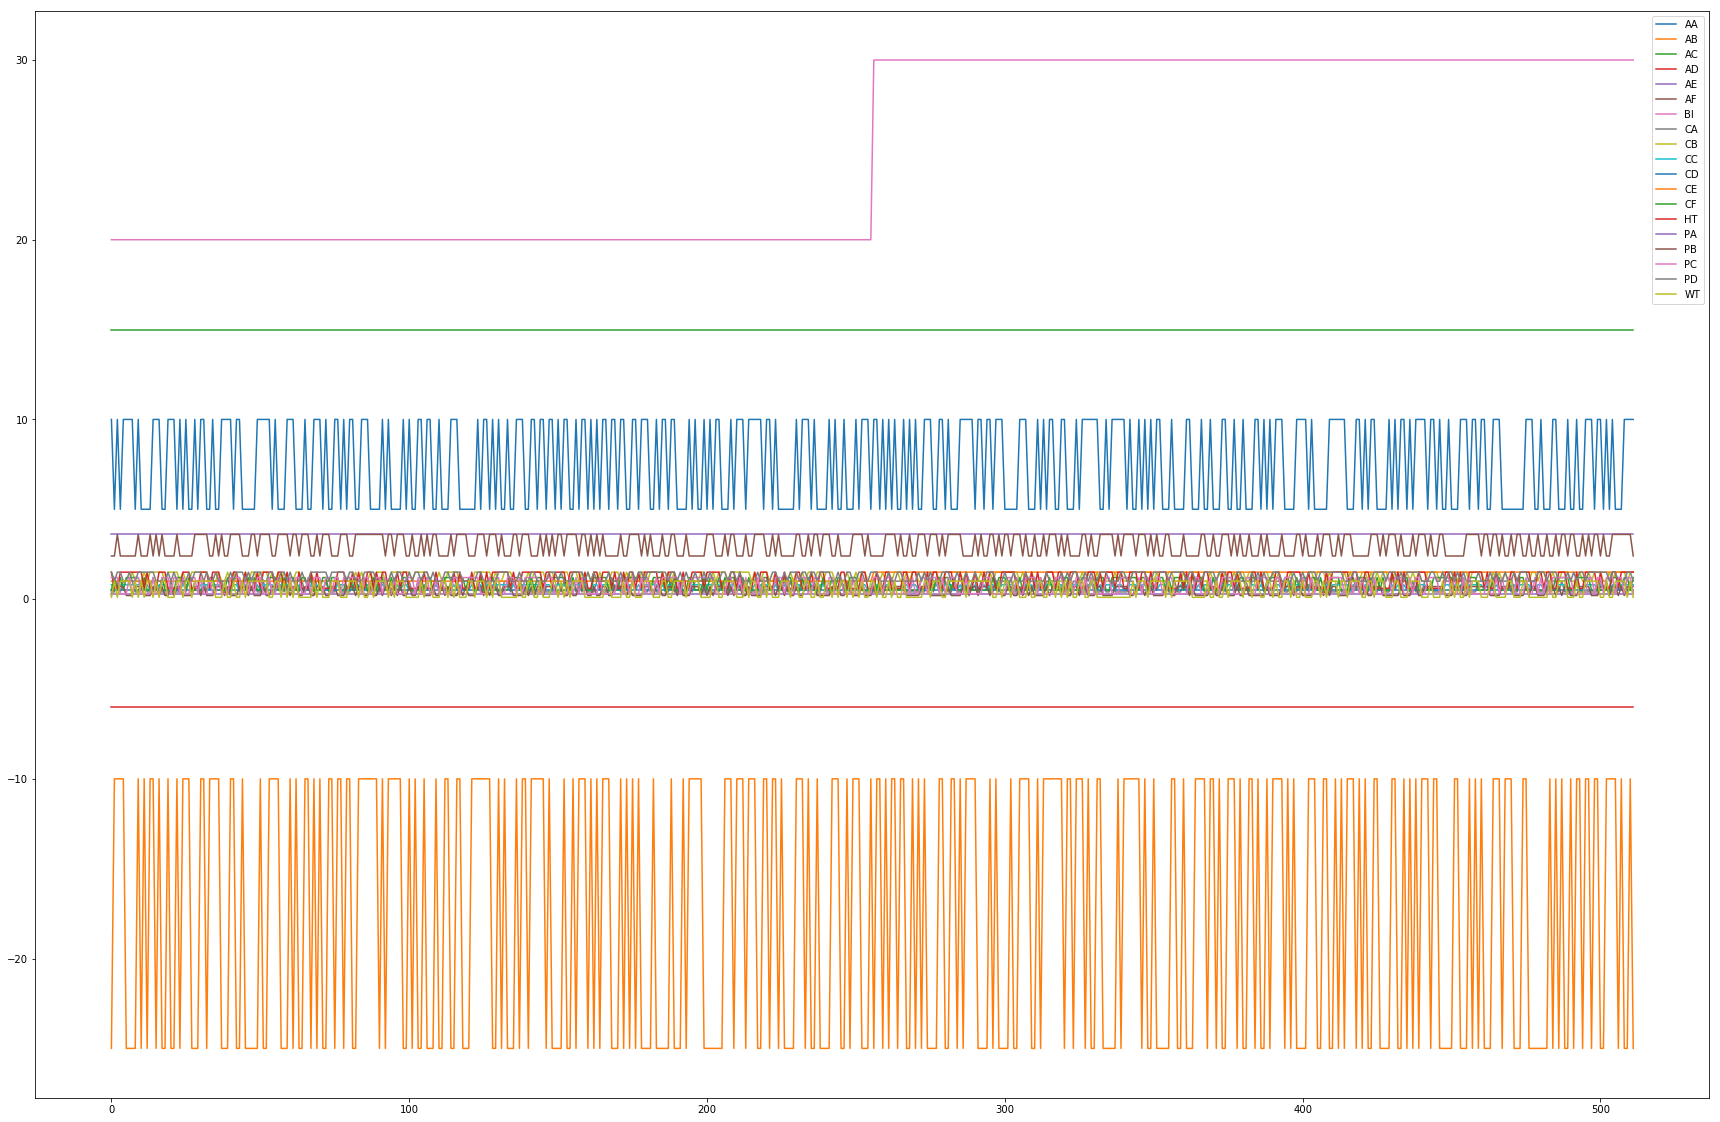

In [37]:

variables_list2 = [
      {"name": "Waveform", "WF_parms_oce": {
            "BI": [20  , 30  , []],
            "AA": [10  , 5   , []],
            "AB": [-25 , -10 , []],
            "AC": [15  , 10  , []],
            "AD": [-6  , -3.6, []],
            "AE": [3.6 , -5  , []],
            "AF": [2.4 , 3.6 , []],
            "WT": [1   , 0.1 , ["CB","AF"]],
            "CA": [0.4 , 1   , []],
            "HT": [0.6 , 1.5 , []],
            "CB": [1   , 1.5 , []],
            "PA": [0.3 , 0.3 , []],
            "CC": [0.5 , 0.8 , ["HT","AE"]],
            "PB": [0.2 , 0.7 , ["CA","CF"]],
            "CD": [0.5 , 0.5 , []],
            "PC": [0.3 , 1.2 , []],
            "CE": [1   , 1.5 , ["BI","CD"]],
            "PD": [1   , 1.5 , ["AA","PC"]],
            "CF": [0.5 , 1.2 , []]
         },
         "randomize_WFs": True
      }
    ]

variables_list3 = [
      {"name": "Waveform", "WF_parms_oce": {
            "BI": [20  , 30  , []],
            "AA": [10  , 5   , []],
            "AB": [-25 , -10 , []],
            "AC": [15  , 15  , []],
            "AD": [-6  , -6, []],
            "AE": [3.6 , 3.6  , []],
            "AF": [2.4 , 3.6 , []],
            "WT": [1   , 0.1 , ["CB","AF"]],
            "CA": [0.4 , 1   , []],
            "HT": [0.6 , 1.5 , []],
            "CB": [1   , 1.5 , []],
            "PA": [0.3 , 0.3 , []],
            "CC": [0.5 , 0.8 , ["HT","AE"]],
            "PB": [0.2 , 0.7 , ["CA","CF"]],
            "CD": [0.5 , 0.5 , []],
            "PC": [0.3 , 1.2 , []],
            "CE": [1   , 1.5 , ["BI","CD"]],
            "PD": [1   , 1.5 , ["AA","PC"]],
            "CF": [0.5 , 1.2 , []]
         },
         "randomize_WFs": True
      }
    ]

#{'PD_delay_us': 85, 'NozzleID': 100, 'BitmapFile': {'file': 'bmp/g4x8_C204_26x33.drp'}, 'Waveform': '00000000'}

loop_settings_deque = get_loop_settings(variables_list3, debug=True)
print(f"Created {len(loop_settings_deque)} loop settings")

# while len(loop_settings_deque) > 0:
#     idx, loop_settings = loop_settings_deque.popleft()
#     if idx == iter:
#         loop_setting_for_WF_file = loop_settings
#     if True:
#         print(f"[{idx:06}] {loop_settings}")

WF_vals_dict_list = []
while len(loop_settings_deque) > 0:
    idx, loop_settings = loop_settings_deque.popleft()
    WF_vals_dict = loop_settings['WF_vals_dict']
    WF_vals_dict_list.append(WF_vals_dict)

df = pd.DataFrame(WF_vals_dict_list)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
df.plot()


In [36]:
'''
{
	"Waveform":	"dis_waveform_onDemand_iter_3.csv",
	"on_demand_iter":	0,
	"WF_vals_dict":	{ "BI":	30},
	"PD_delay_us":	85,
	"NozzleID":	100,
	"BitmapFile":	{"file":	"bmp/g4x8_C204_26x33.drp },
	"sample": 0
}
{
	"on_demand_iter":	1,
	"WF_vals_dict":	{ "BI":	30},
	"sample": 1
}
{
	"on_demand_iter":	2,
	"WF_vals_dict":	{ "BI":	30},
	"PD_delay_us":	90,
	"sample": 0
}
{
	"on_demand_iter":	3,
	"WF_vals_dict":	{ "BI":	30},
	"sample": 1
}
{
	"on_demand_iter":	4,
	"WF_vals_dict":	{ "BI":	30},
	"PD_delay_us":	85,
	"NozzleID":	110,
	"sample": 0
}
{
	"on_demand_iter":	5,
	"WF_vals_dict":	{ "BI":	30},
	"sample": 1
}
{
	"on_demand_iter":	6,
	"WF_vals_dict":	{ "BI":	30},
	"PD_delay_us":	90,
	"sample": 0
}
{
	"on_demand_iter":	7,
	"WF_vals_dict":	{ "BI":	30},
	"sample": 1
	"del_WF_file":	"/home/trafferty/workspace/def/dis_waveform_onDemand_iter_3.csv"	
}
'''


'\n{\n\t"Waveform":\t"dis_waveform_onDemand_iter_3.csv",\n\t"on_demand_iter":\t0,\n\t"WF_vals_dict":\t{ "BI":\t30},\n\t"PD_delay_us":\t85,\n\t"NozzleID":\t100,\n\t"BitmapFile":\t{"file":\t"bmp/g4x8_C204_26x33.drp },\n\t"sample": 0\n}\n{\n\t"on_demand_iter":\t1,\n\t"WF_vals_dict":\t{ "BI":\t30},\n\t"sample": 1\n}\n{\n\t"on_demand_iter":\t2,\n\t"WF_vals_dict":\t{ "BI":\t30},\n\t"PD_delay_us":\t90,\n\t"sample": 0\n}\n{\n\t"on_demand_iter":\t3,\n\t"WF_vals_dict":\t{ "BI":\t30},\n\t"sample": 1\n}\n{\n\t"on_demand_iter":\t4,\n\t"WF_vals_dict":\t{ "BI":\t30},\n\t"PD_delay_us":\t85,\n\t"NozzleID":\t110,\n\t"sample": 0\n}\n{\n\t"on_demand_iter":\t5,\n\t"WF_vals_dict":\t{ "BI":\t30},\n\t"sample": 1\n}\n{\n\t"on_demand_iter":\t6,\n\t"WF_vals_dict":\t{ "BI":\t30},\n\t"PD_delay_us":\t90,\n\t"sample": 0\n}\n{\n\t"on_demand_iter":\t7,\n\t"WF_vals_dict":\t{ "BI":\t30},\n\t"sample": 1\n\t"del_WF_file":\t"/home/trafferty/workspace/def/dis_waveform_onDemand_iter_3.csv"\t\n}\n'